# Conditional VAE

## Process

1. perform model-selection
    - without using CVAE_MODEL, perform hyperparamter grid-search
    - using the total-loss function
2. with the selected model, 
    - initilize the model in CVAE_MODEL
    - fit the model
    - save the model
3. compute DDloss
    - init CVAE_MODEL
    - load the model
    - generate patients
    - compute


In [1]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners.randomsearch import RandomSearch
from kerastuner.tuners.hyperband import Hyperband
from kerastuner.engine.hypermodel import HyperModel

### Random seeds

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## CVAE

### Hyperparameters 
- min_units
- max_units
- activation
- cond_dim
- data_dim
- latent_dim
- e_layers
- d_layers
- learning_rate


## HyperModel

In [120]:
class CVAE(keras.Model):
    
    class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def __init__(self, hp, latent_dim, nr_markers, cond_dim, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        
        self.latent_dim = latent_dim
        self.nr_markers = nr_markers
        self.conditional_dim = cond_dim
        
        self.input_dim = self.nr_markers + self.conditional_dim
        
        self.hp = hp
        
        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
    
    def create_encoder(self):
        """
        PARAMETERS
        ----------
        latent_dim: int
            the dimensision of latent variable
        input_shape: int
            the shape of the input data
        hp : HyperParameter
            the hyperparameters for a specific encoder.

        RETURNS
        -------
        encoder: keras model
            the encoder in the variational autoencoder.
        """
        # An encoder of single selfs.
        # nr_layers
        # nr_units
        # activations 
        # optimizers learning_rate
        
        encoder_inputs = keras.Input(shape=(self.input_dim,), name="encoder_input")
        
        prev_layer = encoder_inputs
        
        if self.hp:
            nr_layers = self.hp.Int('e_layers', 2, 20, step=2) # number of hidden layers
            min_units = self.hp.Fixed('e_min_units', value=2)
            max_units = self.hp.Fixed('e_max_units', value=32)
            act = self.hp.Fixed('activation', value= "relu")
            for l in range(nr_layers):
                units = self.hp.Int("e_unit_l"+ str(nr_layers) + "u"+ str(l) , min_units, max_units, parent_name='e_layers', parent_values=nr_layers)
                prev_layer = layers.Dense(units, activation=act, name="el"+str(l))(prev_layer)
        
        else:
            prev_layer = layers.Dense(10, activation="relu", name="el2")(prev_layer)
            prev_layer = layers.Dense(8, activation="relu", name="el3")(prev_layer)
            prev_layer = layers.Dense(6, activation="relu", name="el4")(prev_layer)
        
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(prev_layer)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(prev_layer)
        z = CVAE.Sampling()([z_mean, z_log_var])
        
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder
        
    def create_decoder(self):
        """
        PARAMETERS
        ----------
        latent_dim: int
            the dimensision of latent variable
        input_shape : int
            the dimension of the input variables
        hp : HyperParameter
            the hyperparameters for a specific decoder.

        RETURNS
        -------
        decoder: keras model
            the decoder in the variational autoencoder.
        """
        decoder_inputs = keras.Input(shape=(self.latent_dim+self.conditional_dim,), name ="latent_variable")
        prev_layer = decoder_inputs
        
        if self.hp:
            nr_layers = self.hp.Int('d_layers', 2, 20, step=2) # number of hidden layers
            min_units = self.hp.Fixed('d_min_units', value=2)
            max_units = self.hp.Fixed('d_max_units', value=32)
            act = self.hp.Fixed('activation', value= "relu")
            
            for l in range(nr_layers):
                units = self.hp.Int("d_unit_l"+ str(nr_layers) + "u" + str(l), min_units, max_units, parent_name='d_layers', parent_values=nr_layers)
                prev_layer = layers.Dense(units, activation=act, name="dl"+str(l))(prev_layer)
        else:
            prev_layer = layers.Dense(6, activation="relu", name="dl2")(prev_layer)
            prev_layer = layers.Dense(8, activation="relu", name="dl3")(prev_layer)
            prev_layer = layers.Dense(10, activation="relu",name="dl4")(prev_layer)

        decoder_outputs = layers.Dense(self.input_dim, activation="relu", name="output_layer")(prev_layer)
        
        decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
        
        return decoder
    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            
            condition = data[:, -self.conditional_dim:]
            
            z_mean, z_log_var, z = self.encoder(data) 
            
            
            condititonal_z = keras.layers.concatenate([z, condition], axis=1)
            conditional_reconstruction = self.decoder(condititonal_z)
            
            # Use MSE as a construction loss, to be set as a parameter.
            mse = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = mse(data, conditional_reconstruction)
            
            # kl-loss
            kl_loss = self.kl_loss(z_mean, z_log_var)
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss,
                "loss": total_loss
        }
    
    def kl_loss(self, mean, log_var):
        kl_loss = 1 + log_var - tf.square(mean) - tf.exp(log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        return kl_loss 
    
    def test_step(self, data):
        x, y = data
        
        # Compute predictions
        y_pred, mean, log_var = self(x, training=False)
        
        # klloss = 
        kl_loss = self.kl_loss(mean, log_var)
        
        # Use MSE as a construction loss, to be set as a parameter.
        mse = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = mse(y, y_pred)
        
        return {
            "kl_loss": kl_loss,
            "reconstruction_loss": reconstruction_loss,
            "loss": kl_loss + reconstruction_loss
        }
        
    def call(self, inputs):
        mean, log_var, encoded = self.encoder(inputs)
        e = keras.layers.concatenate([encoded, inputs[:,-2:]], axis=1)
        decoded = self.decoder(e)
        return decoded, mean, log_var

        #reconst_images = decoder.predict(np.random.normal(0,1,size=(cell_per_patient, self.latent_dim)))


In [92]:
class CVAE_builder(HyperModel):
    
    def __init__(self, hp, latent_dim, nr_markers, cond_dim, **kwargs):
        super(CVAE_builder, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.nr_markers = nr_markers
        self.cond_dim = cond_dim
    
    def build(self, hp):
        model = CVAE(hp, self.latent_dim, self.nr_markers, self.cond_dim)
        
        # Hyperparameter leanring rate
        learning_rate = hp.Choice(name='learning_rate', values = [1e-2, 1e-3, 1e-4])
        optimizer = keras.optimizers.Adam(learning_rate)
        model.compile(optimizer)
        return model
    
    def generate_patients(self
                          , nr_cells = 20000
                          , nr_patients = 20
                          , column_names=None
                          , group=None
                          , model = None): 
        """
        PARAMETERS
        ----------
        nr_cells : int
        nr_patients : int
        column_names : Dataframe.columns
        group : str
            "control" or "diseased"
        
        RETURNS
        -------
        
        patients : dataframe
        
        """

        
        patients = np.empty(shape=(nr_patients * nr_cells, self.nr_markers))
        p_id = np.empty(shape=nr_patients*nr_cells, dtype="int32")

        if group == "control":
            gr = np.concatenate((np.ones(shape=(nr_cells,1)), np.zeros(shape=(nr_cells,1))), axis=1)
        else:
            gr = np.concatenate((np.zeros(shape=(nr_cells,1)), np.ones(shape=(nr_cells,1))), axis=1)

        for i in range(nr_patients):
            # patient ids
            p_id[nr_cells*i : nr_cells*(i+1)] = np.full(shape=(nr_cells), fill_value=i+1, dtype="int32")

            sample = np.random.normal(0,1, size = (nr_cells, self.latent_dim))
            latent_vals = np.concatenate((sample, gr),axis=1)

            # sampled patient cells
            patients[nr_cells*i : nr_cells*(i+1)] = model.decoder.predict(latent_vals)[:,:-self.cond_dim]

        patients_df = pd.DataFrame(patients, columns=column_names)


        patients_df["id"] = p_id
        patients_df["group"] = group

        return patients_df
    
    def callbacks(self, checkpoint_filepath = None, tensorborad_logfile= None, generated_path=None):
        
        callbacks_list=None
        
        # Callback : Checkpoint
        if checkpoint_filepath:

            checkpoint = ModelCheckpoint(checkpoint_filepath
                                         , monitor='loss'
                                         , save_weights_only=True
                                         , verbose=1
                                         , save_best_only=True
                                         , mode='min')
            callbacks_list = [checkpoint]
            
        
        # Callback : Tensorboard
        if tensorborad_logfile:
            
            tboard = keras.callbacks.TensorBoard(
                        log_dir=tensorborad_logfile,
                        write_graph = False,
                        histogram_freq = 0,  # How often to log histogram visualizations
                        embeddings_freq = 0,  # How often to log embedding visualizations
                        update_freq= "epoch",
                    )  # How often to write logs (default: once per epoch)
        
            if not callbacks_list:
                callbacks_list = [tboard]
            else:
                callbacks_list.append(tboard)
                
        # Callback: generate patients after each 10th epoch
        if generated_path:
            # Arbitraty
            genr = Generate(epoch_nr = 10, 
                            col_names = train_p.columns.difference(["group","id"]), 
                            group="control", 
                            latent_dim=self.latent_dim, 
                            cond_dim=self.cond_dim, 
                            nr_markers=self.nr_markers,
                            path = generated_path)
        
            if not callbacks_list:
                callbacks_list = [genr]
            else:
                callbacks_list.append(genr)
        
        return callbacks_list

In [31]:
from keras.callbacks import Callback

In [99]:
class Generate(keras.callbacks.Callback):
    def __init__(self, epoch_nr, col_names, group, latent_dim, cond_dim,nr_markers, path, **kwargs):
        super(Generate,self).__init__(**kwargs)
        
        self.epoch_nr = epoch_nr
        self.col_names = col_names
        self.group = group
        self.cond_dim = cond_dim
        self.latent_dim = latent_dim
        self.nr_markers = nr_markers
        self.path = path
        self.counter = 0
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_nr == 0:
            df = self.generate_patients(group=self.group, nr_cells=50, nr_patients=20)
            df.to_csv(self.path + str(self.counter), index=False)
            self.counter += 1
    
    def generate_patients(self
                          , group
                          , nr_cells = 20000
                          , nr_patients = 20
                          ): 
        """
        PARAMETERS
        ----------
        nr_cells : int
        nr_patients : int
        column_names : Dataframe.columns
        group : str
            "control" or "diseased"
        
        RETURNS
        -------
        
        patients : dataframe
        
        """

        patients = np.empty(shape=(nr_patients * nr_cells, self.nr_markers))
        p_id = np.empty(shape=nr_patients*nr_cells, dtype="int32")

        if group == "control":
            gr = np.concatenate((np.ones(shape=(nr_cells,1)), np.zeros(shape=(nr_cells,1))), axis=1)
        else:
            gr = np.concatenate((np.zeros(shape=(nr_cells,1)), np.ones(shape=(nr_cells,1))), axis=1)

        for i in range(nr_patients):
            # patient ids
            p_id[nr_cells*i : nr_cells*(i+1)] = np.full(shape=(nr_cells), fill_value=i+1, dtype="int32")

            sample = np.random.normal(0, 1, size = (nr_cells, self.latent_dim))
            latent_vals = np.concatenate((sample, gr), axis=1)

            # sampled patient cells
            patients[nr_cells*i : nr_cells*(i+1)] = self.model.decoder.predict(latent_vals)[:,:-self.cond_dim]

        patients_df = pd.DataFrame(patients, columns=self.col_names)


        patients_df["id"] = p_id
        patients_df["group"] = group

        return patients_df

In [107]:
np.random.normal(0,1, size = (20, model.latent_dim))

array([[ 6.27680418e-01,  1.66464182e+00],
       [ 2.63755585e-01, -5.58799572e-01],
       [ 4.67252215e-01, -5.44296146e-01],
       [-5.04422683e-01, -1.51989280e+00],
       [ 9.26257491e-01, -3.86002576e-01],
       [ 1.82098246e-01, -1.03596193e+00],
       [ 4.35947630e-01, -7.61941238e-01],
       [-1.41708722e-01,  8.77826031e-01],
       [ 7.90759312e-01, -2.20300725e-02],
       [-1.76813103e+00,  2.99281057e+00],
       [ 1.74585897e+00,  7.22674825e-01],
       [-7.53203782e-01, -1.13592162e-01],
       [-5.43420430e-01,  1.26385594e+00],
       [ 2.62502891e-01, -7.84163858e-01],
       [-4.70755099e-01,  1.12118814e+00],
       [ 1.60009785e+00,  1.52833156e+00],
       [ 7.57032065e-01, -2.52624869e-01],
       [-3.24151383e+00,  2.97160024e-01],
       [-1.82875884e-03,  1.39982096e-01],
       [ 5.38973470e-02, -1.32626216e+00]])

## Preprocess data

In [39]:
train.columns

Index(['142Nd_Caspase3', '145Nd_CD4', '146Nd_CD8a', '147Sm_CD20', '148Nd_CD16',
       '150Nd_CD86', '151Eu_CD123', '152Sm_p-Akt', '155Gd_CD120a',
       '156Gd_p-p38', '159Tb_CD11c', '160Gd_CD14', '164Dy_IkBa',
       '165Ho_CD120b', '166Er_p-NFkB', '167Er_p-cJun', '169Tm_CD45RA',
       '170Er_CD3', '174Yb_HLA-DR', '176Yb_CD56', '209Bi_CD61', '89Y_CD45',
       'id', 'group'],
      dtype='object')

In [6]:
%%time
# Load data

train = pd.read_csv("ModifiedDATA/RA/UNSTIM/SCALED/A.csv")
val = pd.read_csv("ModifiedDATA/RA/UNSTIM/SCALED/B.csv")

CPU times: user 7.05 s, sys: 296 ms, total: 7.35 s
Wall time: 7.37 s


In [ ]:
# subsample data

SUBSAMPLE_SIZE = 0.5 # take% percent of the data for testing that things work

train = df.groupby('id', group_keys=False).sample(frac=SUBSAMPLE_SIZE, replace=False)
val = df.groupby('id', group_keys=False).sample(frac=SUBSAMPLE_SIZE, replace=False)

In [8]:
# get the markers

# Taken from the paper
phenotyping = ['CD20','CD3','CD4','CD8a','CD45RA', 'CD56', 
               'CD16', 'CD14', 'CD61', 'CD11c','CD123', 'HLA-DR', 'CD45']

functional = ['Caspase3', 'CD86','p-p38','p-Erk','p-Akt','p-cJun','p-NFkB','IkBa','CD120a','CD120b']

functional_columns = list(filter((lambda x : any([i in x for i in functional])), train.columns))
phenotyping_columns = list(filter((lambda x : any([i in x for i in phenotyping])), train.columns))
labels = ["id", "group"]

train_p = train[phenotyping_columns + labels]
val_p = val[phenotyping_columns + labels]
#df_f = data["train"][funcitonal_columns + labels]



In [10]:
def convert_group(df):
    cond = pd.get_dummies(df["group"]).astype("float32")

    data = df[df.columns.difference(["id","group"])]
    data = np.concatenate((data, cond), axis=1)

    return data, (data.shape[1], cond.shape[1]) 

In [11]:
data_train, (data_dim, cond_dim) = convert_group(train_p)

In [12]:
data_val, _ = convert_group(val_p)

## Hyperparameter search

In [124]:
hp = HyperParameters()
latent_dim = 2

hypermodel = CVAE_builder(hp, latent_dim, data_dim - cond_dim, cond_dim)

cvae_path = "GenerativeModels/CVAE"
checkpoint_filepath = cvae_path+ "/checkpoints.tf"
log_dir = cvae_path+ "/tensorboard.log"


"""tuner = RandomSearch(
    hypermodel,
    objective='loss',
    max_trials=5,
    executions_per_trial=3,
    hyperparameters = hp,
    #tune_new_entries=True,
    directory= cvae_path + '/hyperparamsearch',
    project_name='CVAE_random')"""

tuner = Hyperband(hypermodel,
                     objective='loss',
                     max_epochs=10,
                     factor=3,
                     directory= cvae_path + '/hyperparamsearch',
                     project_name='CVAE_hyperband2')

tuner.search_space_summary()

fit_kwargs = {}#{'callbacks': hypermodel.callbacks(checkpoint_filepath,log_dir) }

tuner.search(x=data_train,
             y=None,
             epochs=50,
             validation_data=(data_val, data_val)
             #**fit_kwargs
            )

tuner.results_summary()

INFO:tensorflow:Reloading Oracle from existing project GenerativeModels/CVAE/hyperparamsearch/CVAE_hyperband2/oracle.json
nr_layers:   sdfsdf  2
INFO:tensorflow:Reloading Tuner from GenerativeModels/CVAE/hyperparamsearch/CVAE_hyperband2/tuner0.json
Search space summary
Default search space size: 160
e_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 2, 'sampling': None}
e_min_units (Fixed)
{'conditions': [], 'value': 2}
e_max_units (Fixed)
{'conditions': [], 'value': 32}
activation (Fixed)
{'conditions': [], 'value': 'relu'}
e_unit_l2u0 (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'e_layers', 'values': [2]}}], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': None}
e_unit_l2u1 (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'e_layers', 'values': [2]}}], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': None}
d_layers (Int)
{'default': None, 'conditions': [], 'mi

Results summary
Results in GenerativeModels/CVAE/hyperparamsearch/CVAE_hyperband2
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
e_layers: 8
e_min_units: 2
e_max_units: 32
activation: relu
d_layers: 4
d_min_units: 2
d_max_units: 32
learning_rate: 0.0001
e_unit_l8u0: 8
e_unit_l8u1: 17
e_unit_l8u2: 9
e_unit_l8u3: 14
e_unit_l8u4: 28
e_unit_l8u5: 8
e_unit_l8u6: 6
e_unit_l8u7: 27
d_unit_l4u0: 7
d_unit_l4u1: 11
d_unit_l4u2: 7
d_unit_l4u3: 22
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.384976327419281
Trial summary
Hyperparameters:
e_layers: 8
e_min_units: 2
e_max_units: 32
activation: relu
d_layers: 4
d_min_units: 2
d_max_units: 32
learning_rate: 0.0001
e_unit_l8u0: 8
e_unit_l8u1: 17
e_unit_l8u2: 9
e_unit_l8u3: 14
e_unit_l8u4: 28
e_unit_l8u5: 8
e_unit_l8u6: 6
e_unit_l8u7: 27
d_unit_l4u0: 7
d_unit_l4u1: 11
d_unit_l4u2: 7
d_unit_l4u3: 22
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tune

In [115]:
help(best_hps)

Help on HyperParameters in module kerastuner.engine.hyperparameters object:

class HyperParameters(builtins.object)
 |  Container for both a hyperparameter space, and current values.
 |  
 |  # Attributes:
 |      space: A list of HyperParameter instances.
 |      values: A dict mapping hyperparameter names to current values.
 |  
 |  Methods defined here:
 |  
 |  Boolean(self, name, default=False, parent_name=None, parent_values=None)
 |      Choice between True and False.
 |      
 |      # Arguments
 |          name: Str. Name of parameter. Must be unique.
 |          default: Default value to return for the parameter.
 |              If unspecified, the default value will be False.
 |          parent_name: (Optional) String. Specifies that this hyperparameter is
 |            conditional. The name of the this hyperparameter's parent.
 |          parent_values: (Optional) List. The values of the parent hyperparameter
 |            for which this hyperparameter should be considered 

In [123]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [125]:
model = tuner.hypermodel.build(best_hps)

nr_layers:   sdfsdf  8


In [ ]:
history = model.fit(x = data_train, 
                    y= None, 
                    epochs=150, 
                    validation_data=(data_val, data_val), 
                    callbacks = hypermodel.callbacks(generated_path=cvae_path + "/generated_data"))

Epoch 1/150
63895/63895 [==============================] - 73s 1ms/step - reconstruction_loss: 2.6645 - kl_loss: 0.0494 - loss: 2.7139 - val_kl_loss: 0.0692 - val_reconstruction_loss: 2.7290 - val_loss: 2.7982
Epoch 2/150
63895/63895 [==============================] - 70s 1ms/step - reconstruction_loss: 2.6200 - kl_loss: 0.0832 - loss: 2.7032 - val_kl_loss: 0.0776 - val_reconstruction_loss: 2.4965 - val_loss: 2.5741
Epoch 3/150
63895/63895 [==============================] - 70s 1ms/step - reconstruction_loss: 2.6146 - kl_loss: 0.0877 - loss: 2.7023 - val_kl_loss: 0.0796 - val_reconstruction_loss: 2.5755 - val_loss: 2.6551
Epoch 4/150
63895/63895 [==============================] - 70s 1ms/step - reconstruction_loss: 2.6160 - kl_loss: 0.0870 - loss: 2.7030 - val_kl_loss: 0.0806 - val_reconstruction_loss: 2.5366 - val_loss: 2.6172
Epoch 5/150
63895/63895 [==============================] - 70s 1ms/step - reconstruction_loss: 2.6142 - kl_loss: 0.0883 - loss: 2.7025 - val_kl_loss: 0.0829 - v

# Debugging generated data

In [ ]:

for i in epochs:
    cvae_path + "/generated_data" + epoch

In [77]:
df_p_train

,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,151Eu_CD123,159Tb_CD11c,160Gd_CD14,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,89Y_CD45,id,group
4451395,0.273189,0.000000,0.0,0.0,0.000000,0.00000,0.000000,4.651878,0.0,0.0,0.0,5.499111,0.000000,7,diseased
3319791,0.493877,0.000000,0.0,0.0,0.331495,0.00000,0.000000,3.340704,0.0,0.0,0.0,5.402114,0.000000,0,diseased
4723652,0.000000,0.006000,0.0,0.0,1.097932,0.00000,0.000000,3.644931,0.0,0.0,0.0,5.744494,0.000000,9,diseased
1332053,0.000000,1.699706,0.0,0.0,1.192320,0.00000,0.000000,0.000000,0.0,0.0,0.0,5.625685,0.000000,8,control
5210930,0.393005,0.000000,0.0,0.0,0.009200,1.13379,0.279737,1.114274,0.0,0.0,0.0,5.838879,0.000000,12,diseased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751200,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,5.598567,0.000000,16,diseased
4601172,0.000000,0.000000,0.0,0.0,0.065553,0.00000,0.000000,4.172863,0.0,0.0,0.0,5.652792,0.333768,8,diseased
626927,0.000000,0.000000,0.0,0.0,1.522437,0.00000,0.000000,0.000000,0.0,0.0,0.0,5.873495,0.000000,3,control
3765391,5.123635,0.000000,0.0,0.0,0.000000,0.00000,0.000000,3.945793,0.0,0.0,0.0,5.564770,0.000000,3,diseased


In [30]:
data_train[:,-2:].argmax(axis=1)

array([1, 1, 1, ..., 0, 1, 1])

In [25]:
def plot_label_clusters(encoder, decoder, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    _, _, z = encoder.predict(data)
    group_id_shape = 2
    color = data[:,-group_id_shape:].argmax(axis=1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c = color)
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], label="Means")
    #plt.scatter(z_var[:,0], z_var[:,1], label="Variance")
    #plt.colorbar()
    #plt.legend()
    plt.xlabel("z_0")
    plt.ylabel("z_1")
    plt.show()

No handles with labels found to put in legend.


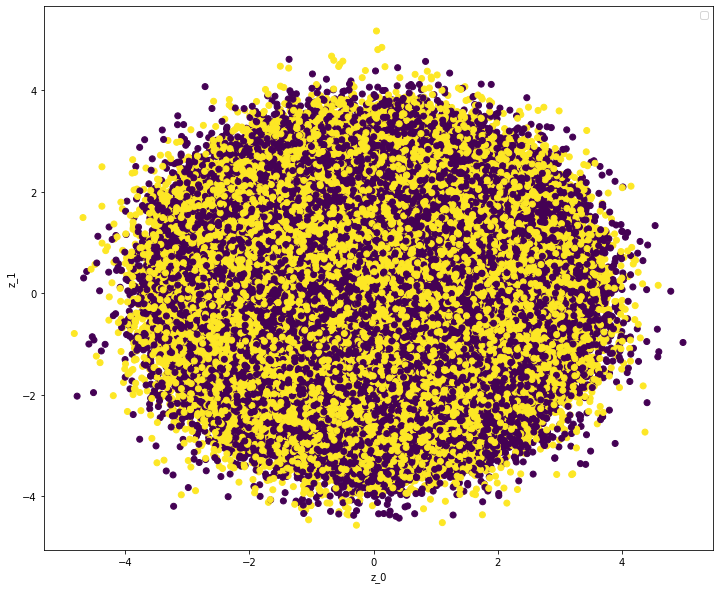

In [26]:
plot_label_clusters(model.encoder, model.decoder, data_train)

In [ ]:
train_p.mean()

In [28]:
hypermodel.generate_patients(20,20,column_names = train_p.columns.difference(["group","id"]), group="control", model=model)



,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,151Eu_CD123,159Tb_CD11c,160Gd_CD14,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,89Y_CD45,id,group
0,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,control
1,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,control
2,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,control
3,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,control
4,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,control
396,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,control
397,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,control
398,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,control


In [29]:
hypermodel.generate_patients(20,20,column_names = train_p.columns.difference(["group","id"]), group="diseased", model=model)


,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,151Eu_CD123,159Tb_CD11c,160Gd_CD14,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,89Y_CD45,id,group
0,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,diseased
1,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,diseased
2,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,diseased
3,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,diseased
4,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,1,diseased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,diseased
396,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,diseased
397,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,diseased
398,0.0,0.0,0.0,0.0,0.28994,0.292684,0.0,2.810978,0.0,0.0,0.0,5.62269,0.0,20,diseased


In [ ]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
bestmodel = tuner.hypermodel.build(best_hps)

fit_kwargs = {'callbacks': hypermodel.callbacks(checkpoint_filepath,log_dir)}

# Retrain the model
bestmodel.fit(x = data_train, y= None, epochs=best_epoch, validation_data=(data_test, data_test), **fit_kwargs)

### CVAE - Model

In [10]:
# SELECTED HYPERPARAMETERS
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(LEARNING_RATE)
EPOCHS = 1
BATCH_SIZE = 128

LATENT_DIM = 2 


model = CVAE(LATENT_DIM, input_shape, group_id_shape)
#model.build((None,input_shape))

model.compile(optimizer=OPTIMIZER)

model.fit(data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

5000/5000 [==============================] - 6s 1ms/step - loss: 1.2068 - reconstruction_loss: 0.7761 - kl_loss: 0.4307 - val_loss: 0.0000e+00


In [12]:
filepath = "GenerativeModels/CVAE_1.tf"
# Save model
model.save(filepath)
# Load Model
loaded_model = keras.models.load_model(filepath)#, custom_objects={"CVAE": CVAE}) 
#don't need the class for loading when using the default saveformat

INFO:tensorflow:Assets written to: GenerativeModels/CVAE_1.tf/assets


In [15]:
generated_control = generate_patients(loaded_model, input_shape-group_id_shape, LATENT_DIM, group_id_shape, 20, 20, cells.columns.difference(["id","group"]), "control")
generated_diseased = generate_patients(loaded_model, input_shape-group_id_shape, LATENT_DIM, group_id_shape, 20, 20, cells.columns.difference(["id","group"]), "diseased")

generated = generated_control.append(generated_diseased)

## Final model for export

In [48]:
modeler = CVAE_MODEL()
modeler.fit(cells,LATENT_DIM, EPOCHS, BATCH_SIZE, OPTIMIZER)
filepath = "GenerativeModels/CVAE_1.tf"
modeler.save(filepath)
modeler.load(filepath)
#modeler.generate_patients()

5000/5000 [==============================] - 7s 1ms/step - loss: 1.4720 - reconstruction_loss: 1.4715 - kl_loss: 5.1036e-04 - val_loss: 0.0000e+00
INFO:tensorflow:Assets written to: GenerativeModels/CVAE_1.tf/assets


## Visualisation

In [35]:
# Add condition
gi = pd.get_dummies(generated["group"]).astype("float32")

d = generated[generated.columns.difference(["id","group"])]
d = np.concatenate((d, gi), axis=1)

In [36]:
def plot_label_clusters(encoder, decoder, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    _, _, z = encoder.predict(data)
    color = data[:,-group_id_shape:].argmax(axis=1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], label="Embedding")
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], label="Means")
    #plt.scatter(z_var[:,0], z_var[:,1], label="Variance")
    #plt.colorbar()
    plt.legend()
    plt.xlabel("z_0")
    plt.ylabel("z_1")
    plt.show()

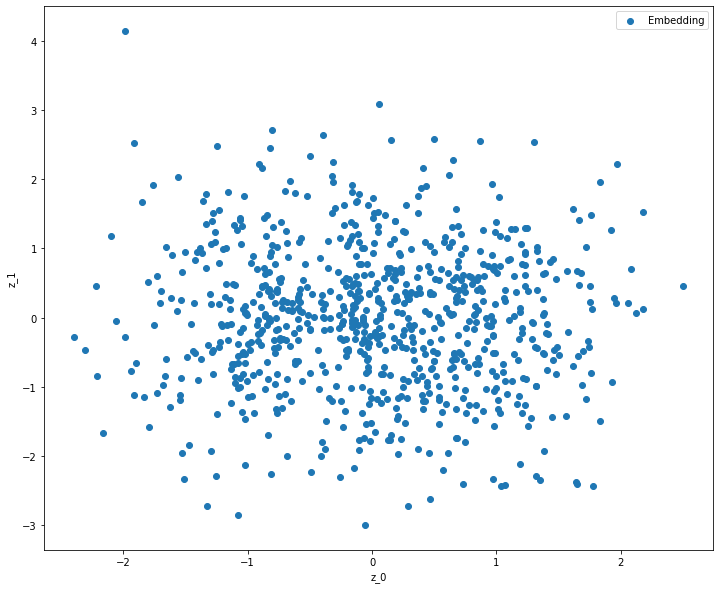

In [37]:
plot_label_clusters(loaded_model.encoder, loaded_model.decoder, d)

### TODO
Hyper parameter search
- get training and test data
- clustering
- 



# Hyperparameter search

In [2]:
import pandas as pd

## DATA

In [16]:
cells = pd.read_csv("ModifiedDATA/scaled_ra.csv")

## Hyperparameters

In [98]:
def rand_dec_layers(size, rang):
    """
    PARAMETERS
    ----------
    size:
    rang: range
    
    RETURNS
    -------
    list of unique random values between a range, sorted
    """
    s,e = rang
    sampled_list = random.choices(range(s,e),k = size)
    sampled_list.sort()
    return sampled_list

In [157]:
def dropout_layers(percent, layers):
    """
    PARAMETERS
    ----------
    percent : double 
        between 0 and 1
    layers : int
        number of layers
    
    RETURNS
    -------
    list of int which layers should have dropouts
    """
    a = list(range(layers))
    random.shuffle(a)
    return a[:int(layers*percent)]

In [170]:
# Hyperparameters

 # Architecture 
e_layers = (2,12) # there should be atleast two layers 
e_units = (2,12)  # there should be atleast two units

hp_encoder = { "nr_hidden_layers": list(range(*e_layers)) , 
               "units_per_layer" : lambda n_layers : rand_dec_layers(n_layers , e_units) , # depends on the choice of nr_hidden_layers 
               "activation_function": ["relu", "sigmoid", "tanh", "selu", "softsign", "elu", "softmax"],
               #"reconstruction_loss": ["mse","mae","mape","msle", "logCos"]}
                "dropout_layer" : lambda n_layers : dropout_layers(0.2, n_layers )} # depends on the choice of nr_hidden_layers. 


d_layers = (2,12) # there should be atleast two layers 
d_units = (2,12) # there should be atleast two layers

hp_decoder = { "nr_hidden_layers": list(range(*d_layers)) , 
               "units_per_layer" : lambda n_layers : rand_dec_layers(n_layers , d_units) , # depends on the choice of nr_hidden_layers 
               "activation_function": ["relu", "sigmoid", "tanh", "selu", "softsign", "elu", "softmax"],
               #"reconstruction_loss": ["mse","mae","mape","msle", "logCos"]}
                "dropout_layer" : lambda n_layers : dropout_layers(0.2, n_layers )} # depends on the choice of nr_hidden_layers

latent_dim = 2 # should be a multiple of 2. One for the mean and one for the standard diviation of the gaussian
conditional_dim = 0 # used if the data is conditional on somethings. This is the dimension of the onehotencoding of that conditioning.


 # Learning algorithm
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate)

optimizers = {"SGD", "Adagrad","RMSprop", "Adam","Adamax","Adadelta","Nadam","Ftrl"}

epochs = 1
batch_size = 128

### Notes

- dim_per_layer is function that takes nr_hidden_layers as input and produceses a list of numbers
- What is the justification of the activation functions?
    - "relu" $max(x,0)$ 
    - "sigmoid" $sigmoid(x) = 1 / (1 + exp(-x))$ 
        - for small values (<-5) return ~0 and for large values (>5) ~1
        - range(0,1)
        - equivalent to 2-element softmax
    - "tanh" $tanh(x)$ 
        - Hyperbolic tangent 
        - range(-1,1)
    - "selu"
        - Scaled Exponential Linear Unit
    - "softplus" $softplus(x) = log(exp(x) + 1)$
        - A smooth approximation to the ReLU
    - "softsign"
        - A less strict sigmoid
    - "elu"
        - The exponential linear unit (ELU) with alpha > 0 is: x if x > 0 and alpha * (exp(x) - 1) if x < 0 
        - ELUs diminish the vanishing gradient effect.
        - The ELU hyperparameter alpha controls the value to which an ELU saturates for negative net inputs.
    - "softmax" $exp(x) / tf.reduce_sum(exp(x))$
        - converts tensor to categorical probablities
        - output vector range(0,1) and sum to 1
    - "exponential"
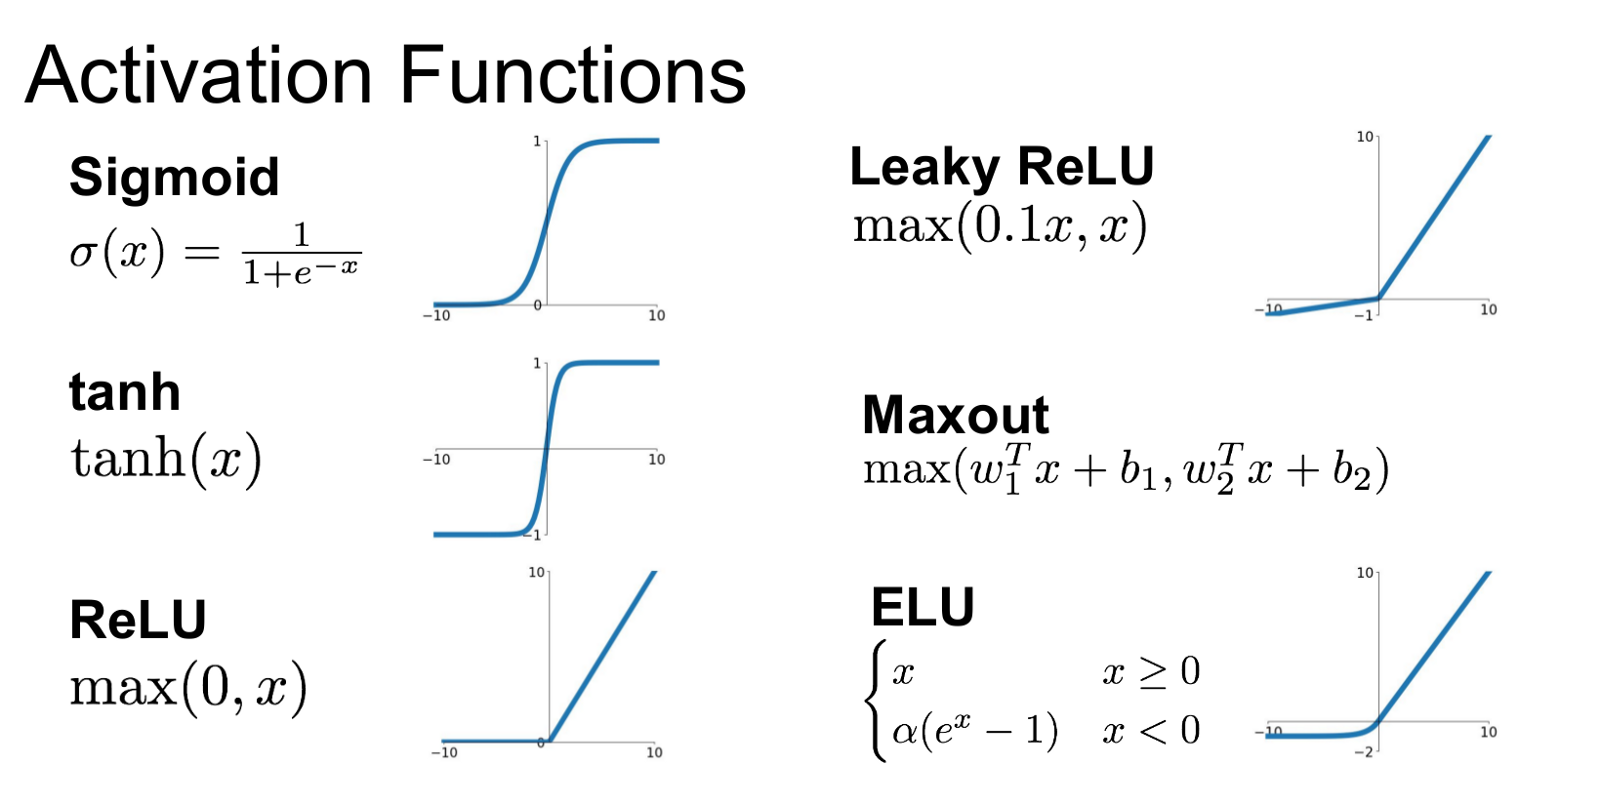
- reconstruction loss:
    - "mse" 
        - incorporates both the variance and bias of the error
        - 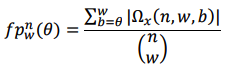
        - If we had a gaussian distribution: the MSE is cross-entropy between the empirical distribution and a gaussian model. src: Deep Learning (by Ian Goodfellow, Yoshua Bengio and Aaron Courville)
            
        > Any loss consisting of a negative log-likelihood is a cross-entropy between the empirical distribution defined by the training set and the probability distribution defined by model. For example, mean squared error is the cross-entropy between the empirical distribution and a Gaussian model."
- [optimizers](https://ruder.io/optimizing-gradient-descent/index.html)
    - ["SGD"](https://dominikschmidt.xyz/nesterov-momentum/)
        - Gradient descent (with momentum) optimizer.
        - Update rule for parameter w with gradient g when momentum is 0:
        > $w = w - learning\_rate * g$
        - Update rule when momentum is larger than 0:
        - velocity = momentum * velocity - learning_rate * g
        > $w = w + velocity$
        - When nesterov=True, this rule becomes:
        > $velocity = momentum * velocity - learning_rate * g$
        > $w = w + momentum * velocity - learning_rate * g$
    - "Adagrad"
        - adaptive learning rate method
    - "RMSprop" (not published) [explanation](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)
        - i.e. Root mean squared propagation
        - adaptive learning rate method
        - extension of adagrad
        - almost similar to Adadelta
        - The gist of RMSprop is to:
        > Maintain a moving (discounted) average of the square of gradients
        > Divide the gradient by the root of this average
    - "Adadelta"
        - extention of adagrad with reduced aggressiveness
        - adaptive learning rate
        - Instead of inefficiently storing  previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients.
    - ["Adam"](https://arxiv.org/abs/1412.6980) [explanation](https://towardsdatascience.com/understanding-gradient-descent-and-adam-optimization-472ae8a78c10)
        - i.e. Adaptive Momentum estimation
        - adaptive learning rate method
        - combination of RMSprop and Momentum
        - Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
        - "well suited for problems that are large in terms of data and/or parameters"
    - "Mometum" (not in keras)
    - "NAG" (not in keras)
        - Nesterov accelerated gradient
    - "Adamax"
        - generalization of Adam, with lp-norm instead of l2-norm
    - "Nadam"
        - combination of Adam and NAG
    - "Ftrl"
    - "AMSgrad"
        - improvement for machinetranslation and object recognistion
- Regularization: <b style="color:red">TODO</b>
    - Dropout, sparcity
    - K-winner dropout
    - layer weight regularizer
    - gaussian noice
    - spacital dropout

### HOW: 
- grid search using [keraswrapper](https://stackoverflow.com/questions/49823192/autoencoder-gridsearch-hyperparameter-tuning-keras) with sklearns gridsearch algorithm 
- using [keras tuner](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/)

In [ ]:
# SELECTED HYPERPARAMETERS
model = CVAE(LATENT_DIM, input_shape, group_id_shape)
#model.build((None,input_shape))

model.compile(optimizer=OPTIMIZER)

model.fit(data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

In [70]:
df_p = data["train"][phenotyping_columns + labels]

In [74]:
df_p.groupby("group").count()

,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,151Eu_CD123,159Tb_CD11c,160Gd_CD14,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,89Y_CD45,id
group,,,,,,,,,,,,,,
control,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098
diseased,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302


In [ ]:
# SELECTED HYPERPARAMETERS
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(LEARNING_RATE)
EPOCHS = 1
BATCH_SIZE = 128


LATENT_DIM = 2 


model = CVAE(LATENT_DIM, input_shape, group_id_shape)
#model.build((None,input_shape))

model.compile(optimizer=OPTIMIZER)

model.fit(data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

In [55]:
df_pf.describe()

,142Nd_Caspase3,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,150Nd_CD86,151Eu_CD123,152Sm_p-Akt,155Gd_CD120a,156Gd_p-p38,...,165Ho_CD120b,166Er_p-NFkB,167Er_p-cJun,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,89Y_CD45,id
count,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,...,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06
mean,1.511458e-02,1.336185e+00,1.183599e-01,8.569858e-02,2.359777e-03,9.519454e-02,2.790618e-01,1.033918e-02,8.355197e-01,3.052695e-02,...,1.918180e+00,7.098109e-01,7.534911e-02,2.821859e+00,1.032783e-02,2.440763e-02,9.844703e-03,5.647810e+00,2.881433e-02,9.500000e+00
std,8.731911e-02,1.839810e+00,4.179470e-01,2.837203e-01,2.866244e-02,3.843423e-01,3.897042e-01,6.490172e-02,9.892413e-01,1.322164e-01,...,8.716810e-01,6.057909e-01,1.901704e-01,1.904091e+00,5.967676e-02,1.051711e-01,5.554857e-02,2.548040e-01,1.226918e-01,5.766282e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.139484e-02,0.000000e+00,...,1.396507e+00,1.559669e-01,0.000000e+00,2.276291e-01,0.000000e+00,0.000000e+00,0.000000e+00,5.566831e+00,0.000000e+00,4.750000e+00
50%,0.000000e+00,3.824111e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.672470e-02,0.000000e+00,5.043452e-01,0.000000e+00,...,1.971310e+00,6.255888e-01,0.000000e+00,3.800661e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.651342e+00,0.000000e+00,9.500000e+00
75%,0.000000e+00,2.004228e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.605460e-01,0.000000e+00,1.185073e+00,0.000000e+00,...,2.474068e+00,1.129350e+00,0.000000e+00,4.316145e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.740956e+00,0.000000e+00,1.425000e+01
max,8.627292e+00,9.663447e+00,9.112473e+00,9.366853e+00,5.351006e+00,5.619878e+00,9.520501e+00,5.339419e+00,8.354411e+00,4.762049e+00,...,6.159187e+00,7.123796e+00,5.208274e+00,6.210354e+00,6.770521e+00,5.332920e+00,5.430301e+00,7.642630e+00,7.436270e+00,1.900000e+01


In [47]:
df_pf.values.shape

(6389440, 24)

In [150]:
from keras.callbacks import ModelCheckpoint

In [178]:
def data_shapes(df):
    cond = pd.get_dummies(df["group"]).astype("float32")
    cols = ["id","group"]
    return df.shape[1]-len(cols)+cond.shape[1], cond.shape[1]

In [212]:
help(modeler.model)

Help on CVAE in module __main__ object:

class CVAE(tensorflow.python.keras.engine.training.Model)
 |  CVAE(*args, **kwargs)
 |  
 |  `Model` groups layers into an object with training and inference features.
 |  
 |  Arguments:
 |      inputs: The input(s) of the model: a `keras.Input` object or list of
 |          `keras.Input` objects.
 |      outputs: The output(s) of the model. See Functional API example below.
 |      name: String, the name of the model.
 |  
 |  There are two ways to instantiate a `Model`:
 |  
 |  1 - With the "Functional API", where you start from `Input`,
 |  you chain layer calls to specify the model's forward pass,
 |  and finally you create your model from inputs and outputs:
 |  
 |  ```python
 |  import tensorflow as tf
 |  
 |  inputs = tf.keras.Input(shape=(3,))
 |  x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
 |  outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
 |  model = tf.keras.Model(inputs=inputs, outputs=outputs)
 |

In [245]:
LATENT_DIM = 2
EPOCHS = 5000
BATCH_SIZE = SUBSAMPLE_SIZE//50
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(LEARNING_RATE)


df_p_train, df_p_val = train_test_split(df_p, test_size=0.2, random_state=RANDOM_SEED, stratify=df_p['id'])

modeler = CVAE_MODEL(LATENT_DIM, OPTIMIZER, *data_shapes(df_p_train))

checkpoint_filepath = "GenerativeModels/CVAE/checkpoints.tf"
log_dir = "GenerativeModels/CVAE/logdir.log"

# tensorboard --log_dir FH/UIB/MASTER/masterShifu/GenerativeModels/CVAE/logdir.log

modeler.fit(  df_p_train
            , df_p_val
            , EPOCHS
            , BATCH_SIZE
            , checkpoint_filepath = checkpoint_filepath
            , log_dir = log_dir
            , tensorboard = True
            , checkpoints = True)



#filepath = "GenerativeModels/CVAE_2.tf"
#modeler.save(filepath)
#modeler.load(filepath)

Epoch 1/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.7447 - reconstruction_loss: 0.7404 - kl_loss: 0.0044 - val_reconstruction_loss: 0.6281
Epoch 2/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5852 - reconstruction_loss: 0.5851 - kl_loss: 5.1062e-05 - val_reconstruction_loss: 0.6266
Epoch 3/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5853 - reconstruction_loss: 0.5853 - kl_loss: 3.0325e-05 - val_reconstruction_loss: 0.6245
Epoch 4/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5856 - reconstruction_loss: 0.5856 - kl_loss: 1.6558e-05 - val_reconstruction_loss: 0.6225
Epoch 5/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5858 - reconstruction_loss: 0.5858 - kl_loss: 9.3869e-06 - val_reconstruction_loss: 0.6241
Epoch 6/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5859 - reconstruction_loss: 0.5859 - kl_loss: 9.0269e-06 - val_reconstruction_los

410/410 [==============================] - 1s 2ms/step - loss: 0.5848 - reconstruction_loss: 0.5848 - kl_loss: 7.5376e-08 - val_reconstruction_loss: 0.6248
Epoch 98/5000
410/410 [==============================] - 1s 3ms/step - loss: 0.5847 - reconstruction_loss: 0.5847 - kl_loss: 5.0758e-08 - val_reconstruction_loss: 0.6243
Epoch 99/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5849 - reconstruction_loss: 0.5849 - kl_loss: 7.8784e-08 - val_reconstruction_loss: 0.6267
Epoch 100/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5846 - reconstruction_loss: 0.5846 - kl_loss: 3.2630e-08 - val_reconstruction_loss: 0.6239
Epoch 101/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5846 - reconstruction_loss: 0.5846 - kl_loss: 8.6760e-08 - val_reconstruction_loss: 0.6259
Epoch 102/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5846 - reconstruction_loss: 0.5846 - kl_loss: 5.6777e-08 - val_reconstruction_loss

410/410 [==============================] - 1s 1ms/step - loss: 0.5830 - reconstruction_loss: 0.5830 - kl_loss: 6.5913e-08 - val_reconstruction_loss: 0.6231
Epoch 146/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5834 - reconstruction_loss: 0.5834 - kl_loss: 6.8741e-08 - val_reconstruction_loss: 0.6242
Epoch 147/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5832 - reconstruction_loss: 0.5832 - kl_loss: 4.0715e-08 - val_reconstruction_loss: 0.6232
Epoch 148/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5830 - reconstruction_loss: 0.5830 - kl_loss: 4.3870e-08 - val_reconstruction_loss: 0.6220
Epoch 149/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5832 - reconstruction_loss: 0.5832 - kl_loss: 6.2795e-08 - val_reconstruction_loss: 0.6222
Epoch 150/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5831 - reconstruction_loss: 0.5831 - kl_loss: 6.2578e-08 - val_reconstruction_lo

Epoch 193/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5831 - reconstruction_loss: 0.5831 - kl_loss: 6.5551e-08 - val_reconstruction_loss: 0.6219
Epoch 194/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5831 - reconstruction_loss: 0.5831 - kl_loss: 6.7508e-08 - val_reconstruction_loss: 0.6235
Epoch 195/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5829 - reconstruction_loss: 0.5829 - kl_loss: 6.3992e-08 - val_reconstruction_loss: 0.6256
Epoch 196/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5831 - reconstruction_loss: 0.5831 - kl_loss: 4.0353e-08 - val_reconstruction_loss: 0.6215
Epoch 197/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5830 - reconstruction_loss: 0.5830 - kl_loss: 4.5102e-08 - val_reconstruction_loss: 0.6234
Epoch 198/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5830 - reconstruction_loss: 0.5830 - kl_loss: 6.5224e-08 - val_re

Epoch 241/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5831 - reconstruction_loss: 0.5831 - kl_loss: 3.1760e-08 - val_reconstruction_loss: 0.6213
Epoch 242/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5830 - reconstruction_loss: 0.5830 - kl_loss: 5.3006e-08 - val_reconstruction_loss: 0.6233
Epoch 243/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5830 - reconstruction_loss: 0.5830 - kl_loss: 3.0781e-08 - val_reconstruction_loss: 0.6220
Epoch 244/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5832 - reconstruction_loss: 0.5832 - kl_loss: 5.6342e-08 - val_reconstruction_loss: 0.6245
Epoch 245/5000
410/410 [==============================] - 1s 2ms/step - loss: 0.5833 - reconstruction_loss: 0.5833 - kl_loss: 5.5798e-08 - val_reconstruction_loss: 0.6242
Epoch 246/5000
410/410 [==============================] - 1s 1ms/step - loss: 0.5832 - reconstruction_loss: 0.5832 - kl_loss: 5.4057e-08 - val_re

KeyboardInterrupt: 

In [237]:
modeler.load_checkpoint(checkpoint_filepath)

In [221]:
locals()["CVAE"]

__main__.CVAE

In [207]:
help(modeler.model)

Help on CVAE in module tensorflow.python.keras.saving.saved_model.load object:

class CVAE(RevivedNetwork, tensorflow.python.keras.engine.training.Model)
 |  CVAE(*args, **kwargs)
 |  
 |  Keras network of layers loaded from a SavedModel.
 |  
 |  Method resolution order:
 |      CVAE
 |      RevivedNetwork
 |      RevivedLayer
 |      tensorflow.python.keras.engine.training.Model
 |      tensorflow.python.keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.training.tracking.tracking.AutoTrackable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.keras.utils.version_utils.LayerVersionSelector
 |      tensorflow.python.keras.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Methods inherited from RevivedLayer:
 |  
 |  get_config(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from RevivedLayer:
 |  
 |  __dict

In [239]:
modeler.fit(  df_p_train
            , df_p_val
            , EPOCHS
            , BATCH_SIZE
            , checkpoint_filepath = checkpoint_filepath
            , checkpoints=True)

Epoch 1/10
41/41 [==============================] - 0s 5ms/step - loss: 0.5850 - reconstruction_loss: 0.5850 - kl_loss: 1.1353e-08 - val_reconstruction_loss: 0.5818

Epoch 00001: loss improved from inf to 0.59515, saving model to GenerativeModels/CVAE_2.tf
Epoch 2/10
41/41 [==============================] - 0s 4ms/step - loss: 0.5846 - reconstruction_loss: 0.5846 - kl_loss: 3.5479e-10 - val_reconstruction_loss: 0.5815

Epoch 00002: loss improved from 0.59515 to 0.58948, saving model to GenerativeModels/CVAE_2.tf
Epoch 3/10
41/41 [==============================] - 0s 5ms/step - loss: 0.5844 - reconstruction_loss: 0.5844 - kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.5813

Epoch 00003: loss improved from 0.58948 to 0.58308, saving model to GenerativeModels/CVAE_2.tf
Epoch 4/10
41/41 [==============================] - 0s 5ms/step - loss: 0.5846 - reconstruction_loss: 0.5846 - kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.5812

Epoch 00004: loss did not improve from 0.58308
Epoch 5/

In [228]:
modeler.model.__dict__

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_build_input_shape': None,
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 15), dtype=tf.float32, name='input_1'),
 '_input_spec': None,
 '_supports_masking': False,
 '_name': 'cvae_39',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x1496663b0>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x14cf92a50>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': True,
 '_layers': [<tensorflow.python.keras.engine.functional.Functional at 0x14cc93750>,
  {}],
 '_inbound_nodes_value': [],
 '_outbound_nodes_value': [],
 '_expects_training_arg': Fal

In [233]:
modeler.model.load_weights(checkpoint_filepath)

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 '_build_input_shape': None,
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 15), dtype=tf.float32, name='inputs'),
 '_input_spec': None,
 '_supports_masking': False,
 '_name': 'cvae_39',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x14c707e30>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x147988240>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': True,
 '_layers': [<tensorflow.python.keras.engine.functional.Functional at 0x14da36190>,
  {},
  {}],
 '_inbound_nodes_value': [],
 '_outbound_nodes_value': [],
 '_dynamic': False,
 '_initial_weights':

In [155]:
val_accuracy_key = 'val_acc'
accuracy_key = 'acc'

#reconstruction_loss
#kl_loss

def plot_training_histories(training_histories, paramdict: dict=None, **kwargs):
    '''Plots given a list of keras training histories, gives a quick summary in plots as well'''
    fig, axes = plt.subplots(len(training_histories), 1, figsize=(12, 2.5*len(training_histories)))
    xepochs = np.arange(1, len(training_histories[0].history['loss'])+1)

    axes = axes.reshape(-1, 2)
    for i, hist in enumerate(training_histories):
        axes[i,0].plot(xepochs, hist.history['loss'], linestyle='--', **kwargs)
        axes[i,0].plot(xepochs, hist.history['kl_loss'], **kwargs)  
        axes[i,0].plot(xepochs, hist.history['reconstruction_loss'],linestyle='dashdot', **kwargs)    
        axes[i,0].plot(xepochs, hist.history["val_reconstruction_loss"], **kwargs)

        if paramdict:
            axes[i,0].text(
                x=-0.55, 
                y=0.55, 
                s=generate_text(hist, paramdict[i]), 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=axes[i,0].transAxes,
    
                fontsize=12)
    
    axes[0,0].set_title("Train/Validation loss")
    axes[0,0].legend(['total_loss', 'kl_loss', 'reconstruction_loss','val_reconstruction_loss'])
    plt.setp(axes[:,0], ylabel='Loss') # Left column
    plt.setp(axes[:,1], ylabel='Accuracy') # Right column
    plt.setp(axes[-1,:], xlabel='Epochs') # Last row
    plt.setp(axes, xticks=xepochs)

    plt.tight_layout()
    plt.show()

In [153]:
modeler.model.history.__dict__

AttributeError: 'NoneType' object has no attribute '__dict__'

AttributeError: 'NoneType' object has no attribute 'history'

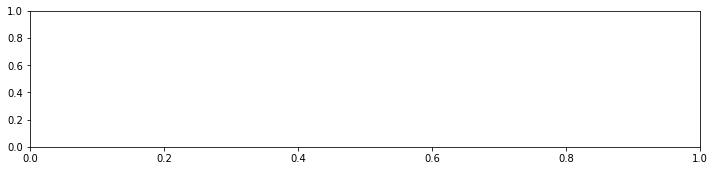

In [156]:
plot_training_histories([modeler.model.history])

In [ ]:
# todo save and load model with checkpoints! [DONE]

In [ ]:
# todo train model and display loss visually TensorBoard  [Done]

In [ ]:
# todo model selection with keras tuner

In [246]:
import kerastuner

In [ ]:
import kerastuner 